# Lecture 06 - softmax regression lab

```
by Seokkyu Kong
Date: 2016-05-07
```

참고 자료: 1 [모두를 위한 머신러닝/딥러닝 강의 - 홍콩과기대 김성훈교수님](http://hunkim.github.io/ml/)

참고 자료: 2, ML lab 06 - multinomial logistic regression classification을 TensorFlow에서 구현하기  
https://www.youtube.com/watch?v=FiPpqSqR_1c&feature=youtu.be


**코세라 연습문제는 one-vs-all 을 이용한 구현이었다.** 따라서 각 클래스마다 각각의 logistic regression model을 구축하고 예측 시 가장 높은 값을 가진 클래스를 선택하는 방식이다.

tensorflow에서는 softmax 함수를 사용하고, 이에 따른 cost function을 구현해서 필기체 숫자 인식 데이터를 적용해 본다.

따라서 기존 예제와 달리 아래 내용을 변경해본다.

- training dataset 은 mxn 으로 읽어서 처리한다. 
- bias term을 포함시킨다.
- 연습문제 3번의 자료는 5000개의 필기체 숫자 이미지이다. 
- 해당 이미지는 20x20 픽셀의 크기로 되어 있다.
- learning rate 및 반복횟수에 따른 비용곡선을 그린다.
- 최적의 learning rate 및 반복횟수를 추정해본다.


In [38]:
%pylab inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

Populating the interactive namespace from numpy and matplotlib


In [39]:
## Part 1: 데이터 로드
# -------------------------
# image 데이터 로딩: 5000x400
# 각 이미지는 20x20 크기이다.
mat_content = sio.loadmat('ex3data1.mat') # 배열 X, y에 저장된 training data

x = mat_content['X']
y = mat_content['y']
y = y.ravel()

# 숫자 "0"은 10의 값을 갖고 있다. 이것을 0번째 인덱스로 설정한다.
for i in xrange(len(y)):
    if y[i] == 10:
        y[i] = 0;

# bias term을 추가한다.
m = x.shape[0]
x_data = np.column_stack((np.ones(m), x))

# y를 one-hot-encoding 적용을 위해서 label encoding으로 변환한다.
y_data = np.zeros((m, 10))
for i in xrange(m):
    y_val = y[i]
    y_data[i, y_val] = 1


print y_data

[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


로딩된 데이터의 모양을 확인해본다.
아래 코드는 코세라 연습문제를 python으로 변환한 작업에서 인용했다.

(100, 400)


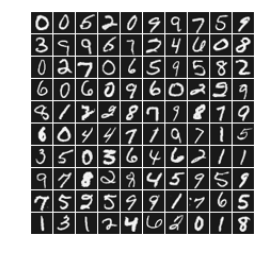

In [40]:
# 아래 함수는 코세라 연습문제에서 이용함
def displayData(X, example_width = 0):
    """
    2D 데이터를 그리드 형식에 표시한다. 
    이 함수는 X에 저장된 2D 데이터를 그리드에 표시한다. 그것은
    그림에 대한 핸들 h와 요청된 배열을 반환한다.
    """
    
    # example_width를 설정한다.
    if example_width == 0:
        example_width = round(np.sqrt(X.shape[1]))
    
    # Gray Image
    # colormap(gray); # In Octave code
    
    # rows, cols 수를 계산한다.
    m, n = X.shape
    example_height = (n / example_width)
    #m = 100, n = 400
    #print('m = %s, n = %s' % (m, n))
    
    example_width = int(example_width)
    example_height = int(example_height)
    #width = 20, height = 20
    #print('width = %s, height = %s' % (example_width, example_height))
    
    # 그려질 item의 갯수를 계산한다.
    display_rows = floor(np.sqrt(m))
    display_cols = ceil(m / display_rows)
    #rows = 10.0, cols = 10.0
    #print('rows = %s, cols = %s' % (display_rows, display_cols))  
    
    # 이미지 사이의 패딩을 설정한다.
    pad = 1
    
    # 비어있는 디스플레이를 설정한다. (211, 211)
    display_array = np.ones((pad + display_rows * (example_height + pad), 
                           pad + display_cols * (example_width + pad)))
    
    # 1 + 100 * (20 + 1)
    #print(display_array.shape)
    
    # 각각의 example을 display array상으로 복사한다.
    # ***************************************************************************
    # XXX: np.arange가 정수를 반환하도록 index 부분은 dtype=int를 주도록 한다.
    # ***************************************************************************
    curr_ex = 0
    for j in np.arange(display_rows, dtype=int):
        for i in np.arange(display_cols, dtype=int):
            if curr_ex >= m:
                break;
                
            # Copy the patch
            
            # Get the max value of the patch
            max_val = np.max(np.abs(X[curr_ex, :]))

            # python에서 인덱스는 0부터 시작한다. (j - 1) => j, (i - 1) => i
            #x = pad + j * (example_height + pad) + np.arange(example_height, dtype=int)
            #y = pad + i * (example_width + pad) + np.arange(example_width, dtype=int)

            x = pad + j * (example_height + pad)
            y = pad + i * (example_width + pad)
            
            #print('x = %s, y = %s' % (x, y))
            #print(display_array[x: x + example_height, y:y + example_width].shape)
            
            # 이미지를 올바르게 보이기 위해서 reshape 후에 transpose 시킨다.
            display_array[x:x + example_height, y: y + example_width] = \
                X[curr_ex, :].reshape((example_height, example_width)).T / max_val;

            curr_ex = curr_ex + 1
            
            if curr_ex >= m:
                break

    # ********************************************************
    # XXX: Ocatave의 imagesc() 는 imshow()로 대체가 가능하다.
    # ********************************************************
    # x, y축의 범위를 -1~1로 설정한다.
    #im = imshow(display_array, interpolation = 'bilinear', 
    #            origin = 'upper', 
    #            extent=(-1,1,-1,1))
    plt.set_cmap('gray')
    im = imshow(display_array)

    # 축을 보여주지 않는다.
    plt.axis('off')
    #show()
    
m = x.shape[0]

# Randomly select 100 data points to display
# Octave의 randperm(n) 함수 대신 random.shuffle(x) 을 사용할 수 있다.
# ****************************************************************
# XXX: random.shuffle()은 객체의 내용 자체를 랜덤하게 섞는다.
# rand_indices: 0~4999
# ****************************************************************
rand_indices = np.arange(m)
random.shuffle(rand_indices)

sel = x[rand_indices[0:100,], :]
print(sel.shape) # 100x400

displayData(sel)

**multinomial regression에서는 softmax 함수와 cost function만 잘 정의하면 된다. 그리고 원리 및 수식을 상세하게 이해할 필요가 있다.** udacity의 강의는 이해하는데 어려웠다. 김성훈교수님의 강의를 듣고 udacity 강좌를 들으면 도움이 많이 될 것이다.

In [48]:
## Part 2: 변수, 가설함수, cost function 및 gradient descent 정의
# ----------------------------------------------------------------
# 변수 선언
X = tf.placeholder(tf.float32, [None, 401]) # bias term 포함
Y = tf.placeholder(tf.float32, [None, 10]) # one-hot encoding 때문에 10개로 선언한다.
W = tf.Variable(tf.random_uniform([401, 10], -1.0, 1.0))


# 가설함수 정의
hypothesis = tf.nn.softmax(tf.matmul(X, W))


# cost function 정의
cost = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(hypothesis), reduction_indices=1))


# gradient descent를 위한 optimize 정의
# XXX: learning_rate도 변수로 선언해서 알파값이 달라질 경우의 비용곡선을 체크한다.
#learning_rate = tf.Variable(1.0)
learning_rate = tf.placeholder(tf.float32)
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train = optimizer.minimize(cost)


# 변수 초기화 및 그래프 시작
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)




my alpha is 0.1
my alpha is 0.3
my alpha is 1.0
my alpha is 3.0


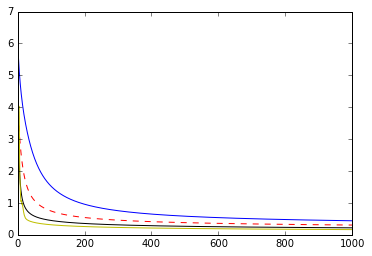

In [58]:
## 적절한 learning rate와 반복횟수를 비용 곡선을 통해서 구한다.
def costFunction(x_data, y_data, my_alpha, num_iters):
    """
    트레이닝 반복횟수 및 learning rate에 따른 비용을 계산한다.
    """
    m = size(y_data)
    J_history = np.zeros(num_iters)
    
    # 반복횟수에 따른 비용값을 배열에 저장한다.
    for step in xrange(num_iters):
        sess.run(train, feed_dict = {X: x_data, Y: y_data, learning_rate: my_alpha})
        cost_tmp = sess.run(cost, feed_dict = {X: x_data, Y: y_data, learning_rate: my_alpha})
        J_history[step] = cost_tmp
        
    return J_history

arr_alpha = [0.1, 0.3, 1.0, 3.0]
num_iters = 1000
arr_J = np.zeros((num_iters, len(arr_alpha)))
i = 0;

for my_alpha in arr_alpha:
    
    # 올바른 cost를 얻기 위해서 변수를 초기화 시켜 준다.
    init = tf.initialize_all_variables()
    sess.run(init)

    # 알파값에 따른 비용을 구한다.
    print('my alpha is %s' % my_alpha)
    J_history = costFunction(x_data, y_data, my_alpha, num_iters)
    arr_J[:, i] = J_history
    i = i + 1
    
plt.plot(arr_J[0:num_iters, 0], 'b')
plt.plot(arr_J[0:num_iters, 1], 'r--')
plt.plot(arr_J[0:num_iters, 2], 'k')
plt.plot(arr_J[0:num_iters, 3], 'y')

learning rate 1.0에서 600~800번 정도 반복하면 될 것 같다.

TODO: learning = 3.0 에서 초기 반복횟수 실행하면, cost가 불규칙적으로 움직이고 있음을 알 수 있다. learning rate = 3.0은 적절하지 않은 것일까?

0 4.17711
100 0.419723
200 0.333971
300 0.296265
400 0.27336
500 0.257333
600 0.245188
700 0.235492


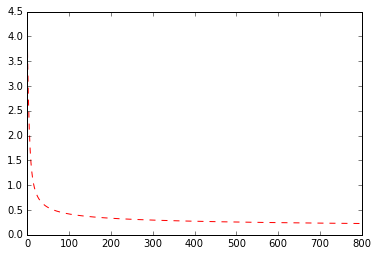

In [59]:
## Part 3: training dataset
# ------------------------------
num_iters = 800
my_alpha = 1.0
arr_J = np.zeros(num_iters)

# 올바른 cost를 얻기 위해서 변수를 초기화 시켜 준다.
init = tf.initialize_all_variables()
sess.run(init)


for step in xrange(num_iters):
    sess.run(train, feed_dict = {X: x_data, Y: y_data, learning_rate: my_alpha})
    cost_tmp = sess.run(cost, feed_dict = {X: x_data, Y: y_data, learning_rate: my_alpha})
    arr_J[step] = cost_tmp
    
    if step % 100 == 0:
        print step, cost_tmp

plot(arr_J, 'r--')



In [60]:
## Part 4: training set에 대한 모델의 정확도를 계산한다.
# -----------------------------------------------------
y_pred = sess.run(hypothesis, feed_dict = {X: x_data})
pred = sess.run(tf.arg_max(y_pred, 1)) 

print('Training set Accuracy: %s' % mean(double(pred == y) * 100))

Training set Accuracy: 93.86
